In [2]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# define the dictionary of digit segments so we can identify
# each digit on the thermostat

DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

The time difference is : 0.5040478079999957
Score:  0.2


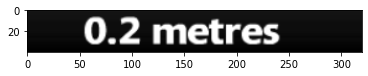

In [130]:
import cv2
from matplotlib import pyplot as plt
import pytesseract
import timeit

image = cv2.imread("/Users/gabimatuszewska/Desktop/qwop_digits/score.png",cv2.IMREAD_GRAYSCALE)

def image_to_text(image):
    text = pytesseract.image_to_string(image)
    score = text.partition(' ')[0]
    return score

starttime = timeit.default_timer()
# print("The start time is :",starttime)
score = image_to_text(image)
print("The time difference is :", timeit.default_timer() - starttime)

plt.imshow(image,'gray')
print("Score: ", score)

In [112]:
mask = np.zeros(image.shape, dtype=np.uint8)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
r,thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area < 800 and area > 200:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh[y:y+h, x:x+w]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        ROI_number += 1

# plt.imshow('mask', mask)
# plt.show()
# plt.imshow('thresh', thresh)

In [90]:
cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
# plt.imshow(cnts,'gray')
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# # loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then we have found
	# the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break

In [42]:
warped = four_point_transform(image, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

In [43]:
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

In [44]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

In [45]:
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

In [46]:
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)

In [50]:
# loop over the segments
for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if total / float(area) > 0.5:
			on[i]= 1
	# lookup the digit and draw it on the image
digit = DIGITS_LOOKUP[tuple(on)]
digits.append(digit)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.putText(output, str(digit), (x - 10, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 101, 101, ..., 101, 101, 101],
       [  0, 100, 100, ..., 100, 100, 100],
       ...,
       [  0,  88,  88, ...,  88,  88,  88],
       [  0,  88,  88, ...,  88,  88,  88],
       [  0,  87,  87, ...,  87,  87,  87]], dtype=uint8)

In [51]:
# display the digits
print(u"{}{}.{} \u00b0C".format(*digits))
cv2.imshow("Input", image)
cv2.imshow("Output", output)
cv2.waitKey(0)

IndexError: Replacement index 1 out of range for positional args tuple